In this journal, we aim to train a functioning audio sentiment model. This model would be utilised in an analyser, which can be represented as:

Audio Object -------> Sentiment Analyser ------> Sentiment Object

The file names for each audio file describes various details about the short audio clip that comes with it, including the emotion. We will use emotion attached to train the model.

In [1]:
import os
import random
from fetch_emotion import get_emotion_number, get_emotion_str
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Activation
from keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt

2023-10-09 23:39:28.343283: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set number of threads
tf.config.threading.set_inter_op_parallelism_threads(8)
tf.config.threading.set_intra_op_parallelism_threads(8)

In [3]:
n_labels = 7

Here, we want to have all the files available for training. We will skip non-wav files.

In [18]:
path = '../audiofiles/'
file_names = []
for path, _, files in os.walk(path):
    for name in files:
        if name[-3:] == 'wav':
            file_names.append(os.path.join(path, name))

Audio features have to be extracted from each audio sample into a data frame.

In [19]:
# Initialise dataframe with 3 columns for features of name, features and emotion
df = pd.DataFrame(columns=['name', 'feature', 'emotion'])

In [20]:
for i, name in enumerate(file_names):
    # Extract data from audio file     
    X, sample_rate = librosa.load(name, res_type='kaiser_fast', duration=3, sr=44100, offset=0.5)
    sample_rate = np.array(sample_rate)
    # Get rand number between -0.4 and 0.4
    rand_shift = random.uniform(-0.4, 0.4)
    # Apply a random time shift
    samples_to_shift = int(len(X) * rand_shift)
    X = np.roll(X, samples_to_shift)
    # Get features of audio data and attach label
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    # Extract label from name    
    label = get_emotion_number(name)
    df.loc[i] = [name, mfccs, label]

Preprocess into suitable dimensions.

In [21]:
feature_df = pd.DataFrame(df['feature'].values.tolist())
labelled_df = pd.concat([feature_df, df['emotion']], axis=1)
labelled_df = labelled_df.dropna()
shuffled_df = labelled_df.sample(frac=1).reset_index(drop=True)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(shuffled_df.drop('emotion', axis=1), 
                                                    shuffled_df['emotion'], 
                                                    test_size=0.3, 
                                                    random_state=17, 
                                                    shuffle = True)

In [23]:
x_train_exp = np.expand_dims(X_train, axis=2)
x_test_exp = np.expand_dims(X_test, axis=2)

Training the model.

In [24]:
model = Sequential()

# Layer 1
model.add(Conv1D(256, 5, padding='same', input_shape=(x_train_exp.shape[1], 1)))
model.add(Activation('relu'))

# layer 2
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))

# Regularisation and Pooling
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=(8)))

# Layer 3
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))

# Converge Nodes and conversion to probability distribution
model.add(Flatten())
model.add(Dense(n_labels)) 
model.add(Activation('softmax')) 

opt = keras.optimizers.RMSprop(learning_rate=0.0001, weight_decay=1e-6)

In [25]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [26]:
history = model.fit(x_train_exp, y_train, batch_size=256, epochs=600, validation_data=[x_test_exp, y_test])

Epoch 1/600
15/15 [==============================] - 5s 263ms/step - loss: 5.0668 - accuracy: 0.1523 - val_loss: 1.9574 - val_accuracy: 0.2506
Epoch 2/600
15/15 [==============================] - 4s 258ms/step - loss: 3.0774 - accuracy: 0.2114 - val_loss: 2.0755 - val_accuracy: 0.2843
Epoch 3/600
15/15 [==============================] - 4s 240ms/step - loss: 2.4168 - accuracy: 0.2756 - val_loss: 1.7851 - val_accuracy: 0.3046
Epoch 4/600
15/15 [==============================] - 3s 225ms/step - loss: 2.0997 - accuracy: 0.3123 - val_loss: 1.4875 - val_accuracy: 0.5343
Epoch 5/600
15/15 [==============================] - 3s 235ms/step - loss: 1.7850 - accuracy: 0.3746 - val_loss: 1.4469 - val_accuracy: 0.4670
Epoch 6/600
15/15 [==============================] - 4s 233ms/step - loss: 1.6215 - accuracy: 0.4102 - val_loss: 1.5138 - val_accuracy: 0.3915
Epoch 7/600
15/15 [==============================] - 4s 244ms/step - loss: 1.5509 - accuracy: 0.4358 - val_loss: 1.3419 - val_accuracy: 0.5013

Epoch 58/600
15/15 [==============================] - 4s 236ms/step - loss: 0.6616 - accuracy: 0.7557 - val_loss: 0.8127 - val_accuracy: 0.6916
Epoch 59/600
15/15 [==============================] - 3s 232ms/step - loss: 0.6754 - accuracy: 0.7516 - val_loss: 0.7103 - val_accuracy: 0.7557
Epoch 60/600
15/15 [==============================] - 4s 254ms/step - loss: 0.6768 - accuracy: 0.7514 - val_loss: 0.6803 - val_accuracy: 0.7862
Epoch 61/600
15/15 [==============================] - 3s 226ms/step - loss: 0.6526 - accuracy: 0.7565 - val_loss: 0.6997 - val_accuracy: 0.7697
Epoch 62/600
15/15 [==============================] - 4s 235ms/step - loss: 0.6426 - accuracy: 0.7696 - val_loss: 0.6924 - val_accuracy: 0.7614
Epoch 63/600
15/15 [==============================] - 3s 236ms/step - loss: 0.6639 - accuracy: 0.7511 - val_loss: 0.6991 - val_accuracy: 0.7544
Epoch 64/600
15/15 [==============================] - 4s 244ms/step - loss: 0.6496 - accuracy: 0.7595 - val_loss: 0.7508 - val_accuracy:

Epoch 115/600
15/15 [==============================] - 4s 240ms/step - loss: 0.5076 - accuracy: 0.8041 - val_loss: 0.5999 - val_accuracy: 0.7830
Epoch 116/600
15/15 [==============================] - 4s 246ms/step - loss: 0.4953 - accuracy: 0.8172 - val_loss: 0.5530 - val_accuracy: 0.8065
Epoch 117/600
15/15 [==============================] - 3s 238ms/step - loss: 0.5059 - accuracy: 0.8153 - val_loss: 0.6004 - val_accuracy: 0.7728
Epoch 118/600
15/15 [==============================] - 3s 223ms/step - loss: 0.5052 - accuracy: 0.8145 - val_loss: 0.5989 - val_accuracy: 0.7747
Epoch 119/600
15/15 [==============================] - 3s 229ms/step - loss: 0.5019 - accuracy: 0.8090 - val_loss: 0.5786 - val_accuracy: 0.7944
Epoch 120/600
15/15 [==============================] - 3s 236ms/step - loss: 0.4974 - accuracy: 0.8183 - val_loss: 0.5432 - val_accuracy: 0.8198
Epoch 121/600
15/15 [==============================] - 4s 240ms/step - loss: 0.4977 - accuracy: 0.8191 - val_loss: 0.6017 - val_ac

15/15 [==============================] - 4s 235ms/step - loss: 0.4084 - accuracy: 0.8526 - val_loss: 0.5005 - val_accuracy: 0.8274
Epoch 172/600
15/15 [==============================] - 4s 241ms/step - loss: 0.4030 - accuracy: 0.8547 - val_loss: 0.4954 - val_accuracy: 0.8217
Epoch 173/600
15/15 [==============================] - 3s 233ms/step - loss: 0.4099 - accuracy: 0.8542 - val_loss: 0.4854 - val_accuracy: 0.8280
Epoch 174/600
15/15 [==============================] - 3s 226ms/step - loss: 0.3935 - accuracy: 0.8564 - val_loss: 0.5013 - val_accuracy: 0.8103
Epoch 175/600
15/15 [==============================] - 4s 237ms/step - loss: 0.4094 - accuracy: 0.8517 - val_loss: 0.4724 - val_accuracy: 0.8395
Epoch 176/600
15/15 [==============================] - 3s 219ms/step - loss: 0.3964 - accuracy: 0.8585 - val_loss: 0.4657 - val_accuracy: 0.8452
Epoch 177/600
15/15 [==============================] - 3s 228ms/step - loss: 0.3975 - accuracy: 0.8569 - val_loss: 0.5065 - val_accuracy: 0.8255

15/15 [==============================] - 3s 226ms/step - loss: 0.3366 - accuracy: 0.8776 - val_loss: 0.5311 - val_accuracy: 0.7995
Epoch 228/600
15/15 [==============================] - 3s 224ms/step - loss: 0.3397 - accuracy: 0.8716 - val_loss: 0.4523 - val_accuracy: 0.8471
Epoch 229/600
15/15 [==============================] - 4s 252ms/step - loss: 0.3262 - accuracy: 0.8779 - val_loss: 0.4569 - val_accuracy: 0.8395
Epoch 230/600
15/15 [==============================] - 3s 229ms/step - loss: 0.3369 - accuracy: 0.8795 - val_loss: 0.4379 - val_accuracy: 0.8376
Epoch 231/600
15/15 [==============================] - 4s 250ms/step - loss: 0.3225 - accuracy: 0.8860 - val_loss: 0.4315 - val_accuracy: 0.8458
Epoch 232/600
15/15 [==============================] - 4s 242ms/step - loss: 0.3277 - accuracy: 0.8844 - val_loss: 0.4282 - val_accuracy: 0.8496
Epoch 233/600
15/15 [==============================] - 3s 228ms/step - loss: 0.3248 - accuracy: 0.8830 - val_loss: 0.4857 - val_accuracy: 0.8122

15/15 [==============================] - 4s 245ms/step - loss: 0.2758 - accuracy: 0.9015 - val_loss: 0.4172 - val_accuracy: 0.8534
Epoch 284/600
15/15 [==============================] - 4s 254ms/step - loss: 0.2775 - accuracy: 0.9013 - val_loss: 0.4240 - val_accuracy: 0.8547
Epoch 285/600
15/15 [==============================] - 4s 250ms/step - loss: 0.2826 - accuracy: 0.8993 - val_loss: 0.4166 - val_accuracy: 0.8623
Epoch 286/600
15/15 [==============================] - 3s 231ms/step - loss: 0.2778 - accuracy: 0.8988 - val_loss: 0.4011 - val_accuracy: 0.8566
Epoch 287/600
15/15 [==============================] - 4s 243ms/step - loss: 0.2753 - accuracy: 0.9013 - val_loss: 0.4337 - val_accuracy: 0.8566
Epoch 288/600
15/15 [==============================] - 4s 240ms/step - loss: 0.2778 - accuracy: 0.8996 - val_loss: 0.4147 - val_accuracy: 0.8484
Epoch 289/600
15/15 [==============================] - 4s 253ms/step - loss: 0.2771 - accuracy: 0.9002 - val_loss: 0.4108 - val_accuracy: 0.8598

15/15 [==============================] - 4s 238ms/step - loss: 0.2279 - accuracy: 0.9219 - val_loss: 0.3809 - val_accuracy: 0.8718
Epoch 340/600
15/15 [==============================] - 4s 239ms/step - loss: 0.2260 - accuracy: 0.9206 - val_loss: 0.3790 - val_accuracy: 0.8699
Epoch 341/600
15/15 [==============================] - 3s 218ms/step - loss: 0.2323 - accuracy: 0.9157 - val_loss: 0.3782 - val_accuracy: 0.8731
Epoch 342/600
15/15 [==============================] - 3s 232ms/step - loss: 0.2210 - accuracy: 0.9197 - val_loss: 0.4094 - val_accuracy: 0.8515
Epoch 343/600
15/15 [==============================] - 4s 238ms/step - loss: 0.2291 - accuracy: 0.9178 - val_loss: 0.4041 - val_accuracy: 0.8522
Epoch 344/600
15/15 [==============================] - 4s 242ms/step - loss: 0.2227 - accuracy: 0.9219 - val_loss: 0.3727 - val_accuracy: 0.8756
Epoch 345/600
15/15 [==============================] - 3s 232ms/step - loss: 0.2297 - accuracy: 0.9184 - val_loss: 0.3776 - val_accuracy: 0.8744

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Trainig Completed. Display results.

In [27]:
train_result = model.evaluate(x_train_exp, y_train, verbose=0)
test_result = model.evaluate(x_test_exp, y_test, verbose=0)

In [28]:
print("Train", "%s: %.2f%%" % (model.metrics_names[1], train_result[1] * 100))
print("Test", "%s: %.2f%%" % (model.metrics_names[1], test_result[1] * 100))

Train accuracy: 98.75%
Test accuracy: 88.01%


We have now finished training the model and so we can save and start using it.

In [29]:
model_name = 'Audio_Sentiment_Model.h5'
save_dir = os.getcwd()
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

Having completed training, we can have a look at how the model performs and find any information that is useful to note. 

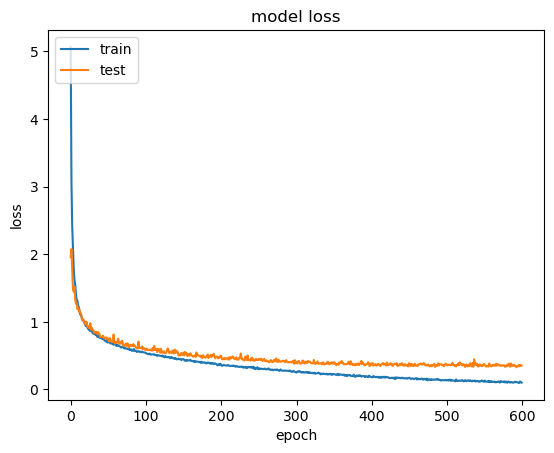

In [30]:
# Loss plotting
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

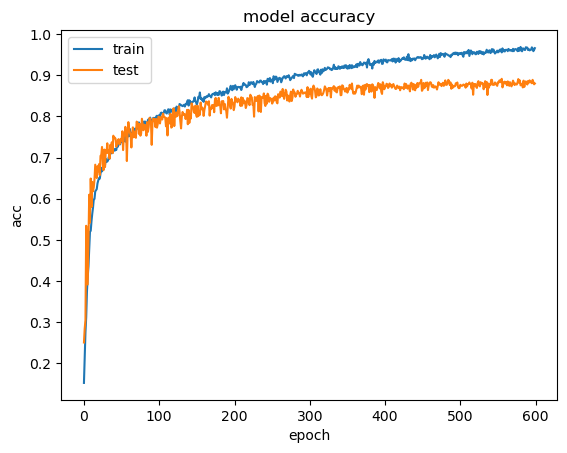

In [31]:
# Accuracy plotting
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [32]:
# Load Model
model = load_model('Audio_Sentiment_Model.h5')

In [33]:
feature_df = pd.DataFrame(df['feature'].values.tolist())
x = np.expand_dims(feature_df, axis=2)
preds = model.predict(x)

165/165 [==============================] - 3s 14ms/step


We can have a look at which emotions are being wrongly guessed.

In [34]:
pred_labels = np.argmax(preds, axis=1)
pred_df = pd.DataFrame({'predictions':pred_labels})
result_df = pd.concat([df, pred_df], axis=1).drop('feature', axis=1)

# Count occurrences of each emotion
emotion_counts = result_df['emotion'].value_counts()

# Count occurrences of wrong predictions
wrong_predictions = result_df[result_df['emotion'] != result_df['predictions']]
wrong_prediction_counts = wrong_predictions['emotion'].value_counts()

# Create a new DataFrame for emotion, occurrences, and wrong predictions
counts_df = pd.DataFrame({'emotion': emotion_counts.index, 
                          'occurrences': emotion_counts.values, 
                          'wrong predictions': wrong_prediction_counts.values,
                          'percentage': wrong_prediction_counts.values / emotion_counts.values * 100})

counts_df['emotion'] = counts_df['emotion'].map(lambda x : get_emotion_str(x))
counts_df

,emotion,occurrences,wrong predictions,percentage
0,neutral,964,84,8.713693
1,sad,776,29,3.737113
2,fearful,776,27,3.479381
3,angry,776,26,3.350515
4,happy,776,25,3.221649
5,surprised,592,23,3.885135
6,disgust,592,21,3.547297


We can look at which correct-wrong pairs are being guessed most.

In [35]:
# Count the occurrences of each 'actual-wrong' pair
correct_wrong_counts = wrong_predictions.groupby(['emotion', 'predictions']).size().reset_index(name='count')
correct_wrong_counts['emotion'] = correct_wrong_counts['emotion'].map(lambda x : get_emotion_str(x))
correct_wrong_counts['predictions'] = correct_wrong_counts['predictions'].map(lambda x : get_emotion_str(x))
correct_wrong_counts = correct_wrong_counts.sort_values(by=['emotion', 'count'], ascending=False)

correct_wrong_counts

,emotion,predictions,count
34,surprised,happy,11
38,surprised,disgust,7
36,surprised,angry,3
35,surprised,sad,2
37,surprised,fearful,2
33,surprised,neutral,1
10,sad,neutral,10
13,sad,fearful,8
11,sad,happy,5
14,sad,disgust,4


It looks like the fearful-sad pair occurs a lot. Perhaps we can understand better if we know if the emotion was normal or strong.

We can look at it predicts different emotions whether it was labelled as strong or normal.

In [ ]:
# TODO:

Additionally, we can see if there's an effect on the model whether the audio clip was speech or song.

In [ ]:
# TODO: